In [1]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [2]:
class ClassifierInterface:
    def train_model(X_train, y_train):
        pass
    
class RandomForest(ClassifierInterface):
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=300, max_features="auto")
    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        
class SVM(ClassifierInterface):
    def __init__(self):
        self.model = SVC(gamma='auto', C=100)
    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

In [3]:
class AppDomainInterface:
    def __init__(self, AbstractClassifier, k, normal):
        pass
    
    def fit(self, X_train):
        pass
    
    def predict(self, X_test, y_test):
        pass
    
    def predict_proba(self):
        pass
    
    def accuracy(self):
        pass
    
    def sensitivity(self):
        pass
    
    def specificity(self):
        pass
    
    def AUC_ROC(self):
        pass
    
    def _get_distance(self, a, b, sort=True):
        pass
    
    def _measure(self, test):
        pass
    
class AppDomainYEuc(AppDomainInterface):
    def __init__(self, classifier, k=5, normal=0.95):
        self.__classifier = classifier
        self.__k = k
        self.__normal = normal
        
    def fit(self, X_train):
        self.__kNN_train_distance_sorted = self._get_distance(X_train, X_train, True)
        index = round(len(self.__kNN_train_distance_sorted) * self.__normal) - 1  #find max distance number's index
        self.__threshold = self.__kNN_train_distance_sorted[index]     #max distance number
        
    def predict(self, X_test, y_test):
        dist_measure = self._measure(X_test) #Measures if its within the distance model
        
        self.__inOrOut = dist_measure <= 1     #creates true or false list of whether it fits the model
        
        self.__y_test = y_test
        self.__y_pred = self.__classifier.model.predict(X_test)
        self.__y_pred[~self.__inOrOut] = 0       #makes all outliers false
        
        self.__predict_proba = self.__classifier.model.predict_proba(X_test)
        self.__predict_proba[~self.__inOrOut][0] = 1
        self.__predict_proba[~self.__inOrOut][1] = 0
        
        self.__accuracy = accuracy_score(y_test, self.__y_pred)
        self.__confusion_matrix = confusion_matrix(y_test, self.__y_pred)
        tn, fp, fn, tp = self.__confusion_matrix.ravel()
        self.__sensitivity = tp / (tp + fn)
        self.__specificity = tn / (tn + fp)
        
        self.__AUC_ROC = roc_auc_score(y_test, self.__predict_proba[:, 1])
        
        print("Accuracy:",self.__accuracy)
        
        return self.__y_pred
        
    
    def predict_proba(self):
        return self.__predict_proba
    
    def accuracy(self):
        return self.__accuracy
    
    def sensitivity(self):
        return self.__sensitivity
    
    def specificity(self):
        return self.__specificity
    
    def AUC_ROC(self):
        return self.__AUC_ROC
    
    def AUC_random(self):
        return 0.5 * (self.__sensitivity + self.__specificity)
    
    def AUC_max(self):
        return 1 - ((1-self.__sensitivity) * (1-self.__specificity))
    
    def show_ROC_curve(self):
        fpr, tpr, thresh = roc_curve(self.__y_test, self.__predict_proba[:, 1], pos_label=1)
        
        random_probs = [0 for i in range(len(self.__y_test))]
        p_fpr, p_tpr, p_thresh = roc_curve(self.__y_test, random_probs, pos_label=1)
        
        plt.style.use('seaborn-whitegrid')
        plt.plot(fpr, tpr, linestyle='--', color='blue', label='Y Euclidean')
        plt.plot(p_fpr, p_tpr, linestyle='--', color='green')
        
        plt.title('ROC curve')
        plt.xlabel('False Positive rate')
        plt.ylabel('True Positive rate')
        
        plt.legend(loc='best')
        plt.savefig('ROC_Y_Euclidean', dpi=300)
        plt.show
        
    
    def _get_distance(self, XA, XB, sort=True):
        distance = cdist(XA, XB, metric='euclidean')
        distance.sort()
        
        kNN_distance = np.mean(distance[:, :self.__k+1], axis=1)
        if sort:
            kNN_distance.sort()
        return kNN_distance
    
    def _measure(self, X_test):                    
        self.__kNN_train_test_distance = self._get_distance(X_test, X_train, False)
        
        measure = self.__kNN_train_test_distance / self.__threshold
        return measure

In [4]:
files_path = os.path.join(os.getcwd(), 'datasets')

dataset_files = [os.path.join(files_path, file) for file in os.listdir(files_path)]

features = pd.read_csv(dataset_files[0])

In [5]:
X = features.iloc[:, :-1].values
y = features.iloc[:, -1].values

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
model = RandomForest()
model.train_model(X_train, y_train)

model2 = SVM()
model2.train_model(X_train, y_train)

ad = AppDomainYEuc(model)

ad.fit(X_train)

In [8]:
ad.predict(X_test, y_test)

Accuracy: 0.7843438219493477


array([0., 0., 1., ..., 0., 0., 0.])

In [10]:
print(f"Sensitivity: {ad.sensitivity()}")

Sensitivity: 0.7464788732394366


In [11]:
print(f"Specificity: {ad.specificity()}")

Specificity: 0.8296795952782462


In [12]:
print(f"AUC ROC: {ad.AUC_ROC()}" )

AUC ROC: 0.8694368572310762


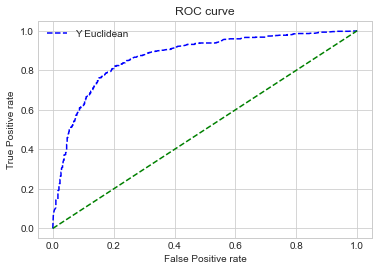

In [13]:
ad.show_ROC_curve()